In [1]:
import pandas as pd

In [2]:
races = pd.read_csv('Data/races.csv')

monza = races[races['circuitId'] == 14]['raceId']
races_monza = []
[races_monza.append(i) for i in monza];

In [3]:
results = pd.read_csv('Data/lap_times.csv')

races_monza_results = results[results['raceId'].isin(races_monza)]
races_monza_results = races_monza_results[['driverId','milliseconds']]

hamilton = races_monza_results[races_monza_results['driverId'] == 1]
bottas = races_monza_results[races_monza_results['driverId'] == 822]
verstappen = races_monza_results[races_monza_results['driverId'] == 830]
perez = races_monza_results[races_monza_results['driverId'] == 815]

len(bottas), len(verstappen), len(hamilton), len(perez)

(424, 293, 688, 509)

In [4]:
perez

,driverId,milliseconds
15851,815,126009
15852,815,142894
15853,815,136145
15854,815,94026
15855,815,93944
...,...,...
480364,815,85490
480365,815,84336
480366,815,84821
480367,815,84632


In [5]:
import numpy as np
import scipy.stats as st     # Librería estadística
import statsmodels.api as sm 
import matplotlib.pyplot as plt
import pandas as pd

In [6]:
hamilton = hamilton.reset_index()

In [7]:
hami = hamilton['milliseconds'].to_numpy()

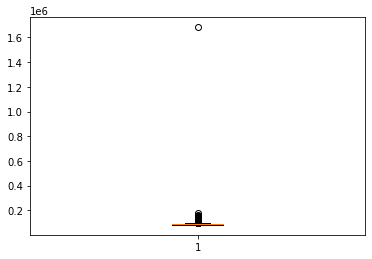

In [8]:
b = plt.boxplot(hami);
plt.show()

Vemos por medi odel boxplot, que el piloto hamilton tiene muchos valores extremos que no queremos en la muestra, asi que se limpia

In [9]:
lims = [item.get_ydata()[1] for item in b['whiskers']]

hami = hami[(hami > lims[0]) & (hami<lims[1])]

In [10]:
len(hami)

626

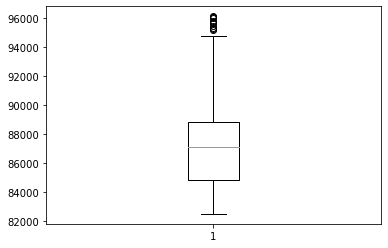

In [11]:
plt.boxplot(hami);

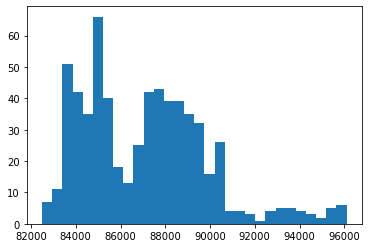

In [12]:
plt.hist(hami, bins=30);

El histograma arroja una distribucion que a simple vista parece bimodal

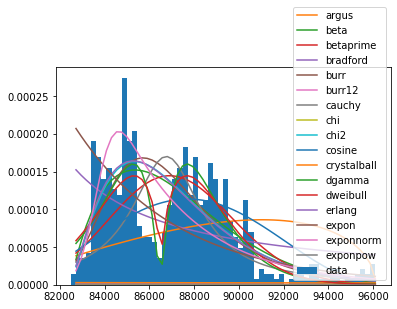

In [35]:
import warnings
warnings.filterwarnings('ignore')

y,x, _ = plt.hist(hami, bins=60,density=True,label='data')
x = x[1:]

dist = [d for d in dir(st) if isinstance(getattr(st,d),getattr(st,'rv_continuous'))]
dist = dist[3:20]
error = pd.DataFrame(index=dist,columns=['error'])

def erdist(d):
    params = getattr(st,d).fit(hami)
    y_hat = getattr(st, d)(*params).pdf(x)
    error.loc[d] = ((y - y_hat)**2).mean()
    plt.plot(x,y_hat,label=d)
    
[erdist(d) for d in dist]    
    
    
plt.legend()
plt.show()

In [36]:
best = error.sort_values(by='error').head().index.values
best

array(['dgamma', 'dweibull', 'beta', 'erlang', 'chi2'], dtype=object)

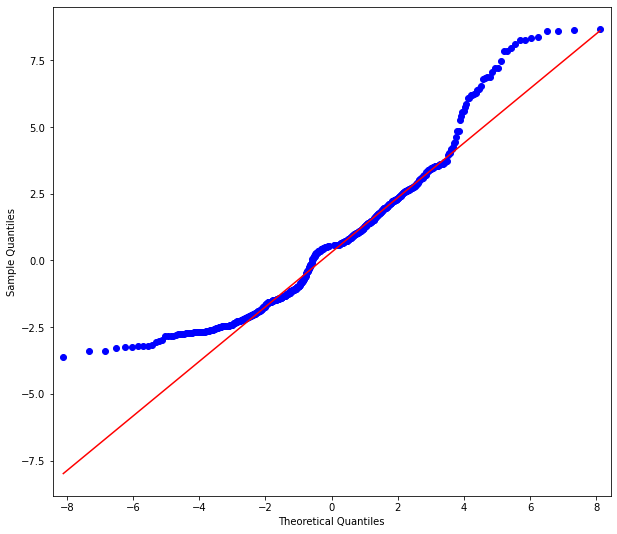

In [37]:
dist = best
fig, ax = plt.subplots(1,1, figsize=[10,9])
grap1 = sm.qqplot(hami,dist=getattr(st, best[0]), line='q', fit=True, ax=ax)

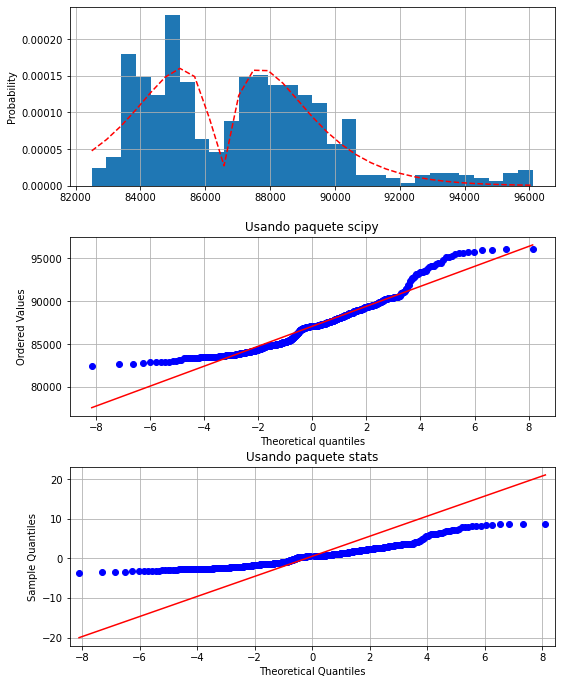

In [38]:
measurements = hami

# Histograma de las variables creadas
divisiones = 30 # Cantidad de barras en el histograma
fig, ax = plt.subplots(3,1, figsize=(8,10))
fig.tight_layout(pad=3.0)

y, x, _ = ax[0].hist(measurements, divisiones, density=True, label='Histograma mediciones')

# Función de distribución de probabilidad la cual creemos que mis datos distribuyen 
# RECORDAR: SÓLO FUNCIONA PARA DISTRIBUCIONES CONTINUAS
dist = 'dgamma'
params = getattr(st, dist).fit(measurements)

# Graficar PDF de la distribución que queremos probar

# x = np.arange(measurements.min(), measurements.max(), .01)
y_hat = getattr(st, dist).pdf(x, *params)
ax[0].plot(x, y_hat,'r--', label='Distribución ajustada')
ax[0].set_ylabel('Probability')
ax[0].grid()

# gráfica de Q-Q entre mis datos y la curva que quiero probar que sigue mi distribución (dist)
# Usando scipy
grap2 = st.probplot(measurements, dist=dist, sparams=getattr(st, dist).fit(x)[:-2], plot=ax[1], fit=True)
ax[1].grid()
ax[1].set_title('Usando paquete scipy')

grap1 = sm.qqplot(measurements, dist=getattr(st, dist), line='s', fit=True, ax=ax[2])
ax[2].grid()
ax[2].set_title('Usando paquete stats')

# plt.xlabel(f'{dist.title()} theorical quantiles')
# plt.ylabel('Data theorical quantiles')
plt.show()

Logra ajustarse, pero no adecuadamente, ya que las colas se salen por mucho de la recta

In [14]:
np.random.seed(5555)
# Comparación de dos conjuntos de datos
x = np.random.normal(loc=8.5, scale=2.5, size=100)
y = np.random.normal(loc=8.0, scale=3.0, size=100)

# Gráfica de las dos normales
x1 = np.arange(1,627,1)
y1 = hami
y2 = st.norm.pdf(x1, loc=8.0, scale=3)

In [15]:
np.mean(hami), np.std(hami)

(87085.9249201278, 2802.0059586172533)

H0: Hamilton tiene un distribucion normal

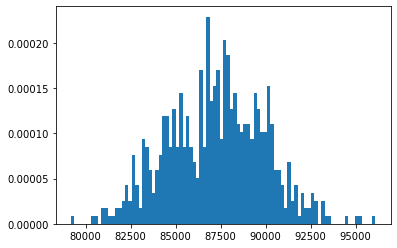

media mu =87541.370034, desviación estándar muestral =4878.930200


In [16]:
np.random.seed(557)
# Parámetros reales de la PDF
mu_real = 87085.92; sigma_real = 2802

# Cantidad de muestras
N = 627
n1 = np.random.normal(mu_real, sigma_real, N)

J = 90  # Cantidad de particiones del histograma

y, x, _ = plt.hist(n1, J, density=True)
plt.show()

# Se obvia el último valor de x para obtener exactamente J muestras de x
x = x[:-1] 

# Media y desviación estándar muestral
mu = np.mean(x)
sigma = np.std(x)
print('media mu =%f, desviación estándar muestral =%f'%(mu,sigma))

Vemos que la media de la muestra generada es casi identica a la real

In [17]:
pi = st.norm.pdf(x, loc=mu, scale=sigma)

# Cálculo de la esperanza usando la expresión teórica
Ei = x*pi

# Cálculo teórico de la chi cuadrada
x2 = np.sum(list(map(lambda Ei, obs_i:(obs_i - Ei)**2 / Ei, Ei, y)))
print('Valor de chi cuadrado teorico  = ', x2)

# Cálculo usando la librería estadística de la chi cuadrada
X2 = st.chisquare(y, Ei)
print('Valor de chi cuadrado librería = ', X2)

# Cálculo de Grados de libertad del estadístico
p = 2 # Parámetros estimados con los datos
m = J-p-1 # grados de libertad

Chi_est = st.chi2.ppf(q=0.95, df=m)
print('Estadístico de chi_cuadrado = ', Chi_est)
print('Media muestral = ', mu, '\nDesviación estándar muestral = ', sigma)

Valor de chi cuadrado teorico  =  427.33165407857683
Valor de chi cuadrado librería =  Power_divergenceResult(statistic=427.33165407857683, pvalue=1.112158624766836e-45)
Estadístico de chi_cuadrado =  109.77330935028795
Media muestral =  87541.37003368814 
Desviación estándar muestral =  4878.930200315013


El chi cuadrado tiene un valor bajo, pero no lo sufuciete, ademas su pvalue es 0, por lo que rechazamos la hipotesis nula

In [18]:
import numpy as np
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate

def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)


def kde_statsmodels_u(x, x_grid, bandwidth=0.2, **kwargs):
    """Univariate Kernel Density Estimation with Statsmodels"""
    kde = KDEUnivariate(x)
    kde.fit(bw=bandwidth, **kwargs)
    return kde.evaluate(x_grid)
    
    
def kde_statsmodels_m(x, x_grid, bandwidth=0.2, **kwargs):
    """Multivariate Kernel Density Estimation with Statsmodels"""
    kde = KDEMultivariate(x, 
                          bw='cv_ml',  #bandwidth * np.ones_like(x),
                          var_type='c', **kwargs)
    return kde.pdf(x_grid)


def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)


kde_funcs = [kde_statsmodels_u, kde_statsmodels_m, kde_scipy, kde_sklearn]
kde_funcnames = ['Statsmodels-U', 'Statsmodels-M', 'Scipy', 'Scikit-learn']

print( "Package Versions:")
import sklearn; print( "  scikit-learn:", sklearn.__version__)
import scipy; print ("  scipy:", scipy.__version__)
import statsmodels; print( "  statsmodels:", statsmodels.__version__)

Package Versions:
  scikit-learn: 0.23.2
  scipy: 1.5.2
  statsmodels: 0.12.0


In [19]:
x = np.array([1,2,3,4])
x[:,np.newaxis].shape, x.shape

((4, 1), (4,))

In [20]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

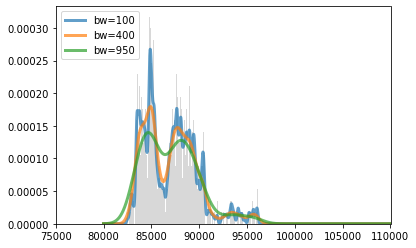

In [21]:
from scipy.stats.distributions import norm

# The grid we'll use for plotting
x_grid = np.linspace(80000, 110000, 100000)

fig, ax = plt.subplots()
for bandwidth in [100, 400, 950]:
    ax.plot(x_grid, kde_sklearn(hami, x_grid, bandwidth=bandwidth),
            label='bw={0}'.format(bandwidth), linewidth=3, alpha=0.7)
ax.hist(hami, 150, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.set_xlim(75000, 110000)
ax.legend(loc='upper left')

In [22]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(100, 600, 100)},
                    cv=50) # 20-fold cross-validation
grid.fit(hami[:, None])
print(grid.best_params_)

{'bandwidth': 488.88888888888886}


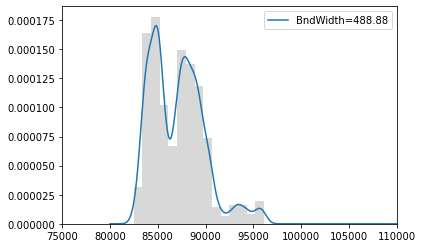

In [23]:
pdf = kde_sklearn(hami, x_grid, bandwidth=488.88)

plt.plot(x_grid, pdf, label='BndWidth=488.88')
plt.hist(hami, 15, fc='gray',histtype='stepfilled', alpha=0.3, density=True)
plt.legend(loc='upper right')
plt.xlim(75000, 110000)
plt.show()

In [24]:
media, desviacion = st.norm.fit(hami)
d, pvalor = st.kstest(hami,"norm",args=(media,desviacion))

In [25]:
pvalor

1.3034542625280808e-06

El pvalue de Kolmogorov es muy chico para aceptarlo